In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json again

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deeyahthakur","key":"9ae942ef6b411e53bd7b89ebe569639d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s chest-xrays

ref                                                              title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
nih-chest-xrays/data                                             NIH Chest X-rays                                    45096150231  2018-02-21 20:52:23.880000         114495       1339  0.7352941        
nih-chest-xrays/sample                                           Random Sample of NIH Chest X-ray Dataset             4506359620  2017-11-23 02:58:24.087000          22669        279  0.7647059        
jesperdramsch/siim-acr-pneumothorax-segmentation-data            SIIM ACR Pneumothorax Segmentation Data              3256848012  2019-06-25 20:18:45.713000           8398        136  0.647058

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nickuzmenkov/nih-chest-xrays-tfrecords")

print("Path to dataset files:", path)

100%|██████████| 11.2G/11.2G [01:34<00:00, 127MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/nickuzmenkov/nih-chest-xrays-tfrecords/versions/3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /root/.cache/kagglehub/datasets/nickuzmenkov/nih-chest-xrays-tfrecords/versions/3 /content/drive/MyDrive/nih_tfrecord_data

In [ ]:
data_dir = "/content/drive/MyDrive/nih_tfrecord_data"

tfrecord_dir = f"{data_dir}/data/"
csv_path = f"{data_dir}/preprocessed_data.csv"

In [ ]:
import pandas as pd

df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,../input/data/images_001/images/00000001_000.png,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,../input/data/images_001/images/00000001_001.png,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,../input/data/images_001/images/00000001_002.png,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,../input/data/images_001/images/00000002_000.png,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,../input/data/images_001/images/00000003_000.png,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [ ]:
import os
import tensorflow as tf

tfrecord_files = tf.io.gfile.glob(os.path.join(tfrecord_dir, '*.tfrec'))

print(f"Found {len(tfrecord_files)} TFRecord files.")


Found 256 TFRecord files.


In [ ]:
feature_map= {}

for elem in list(df.columns)[1:]:
    feature_map[elem] = tf.io.FixedLenFeature([], tf.int64)

feature_map['image'] = tf.io.FixedLenFeature([], tf.string)
feature_map

{'No Finding': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Atelectasis': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Consolidation': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Infiltration': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Pneumothorax': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Edema': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Emphysema': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Fibrosis': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Effusion': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Pneumonia': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Pleural_Thickening': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Cardiomegaly': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Nodule': FixedLenFeature(shape=[], dtype=tf.int64, defa

In [ ]:
import tensorflow as tf
import os

# List of conditions (excluding 'image')
diseases = [
    'No Finding', 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
    'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Define parsing function for TFRecord files
def parse_multilabel_tfrecord(example_proto):
    feature_description = {disease: tf.io.FixedLenFeature([], tf.int64) for disease in diseases}
    feature_description['image'] = tf.io.FixedLenFeature([], tf.string)

    # Parse the example
    example = tf.io.parse_single_example(example_proto, feature_description)

    # Decode the image and normalize it
    image = tf.io.decode_jpeg(example['image'], channels=1)
    image = tf.image.resize(image, [224, 224]) / 255.0

    # Create a label vector
    label = [example[disease] for disease in diseases]
    label = tf.stack(label)

    return image, label

# Function to split dataset
def get_train_test_datasets(tfrecord_files, train_size=0.8, batch_size=32):
    # Shuffle the file paths and split them into train and test sets
    train_files = tf.random.shuffle(tfrecord_files)[:int(len(tfrecord_files) * train_size)]
    test_files = tf.random.shuffle(tfrecord_files)[int(len(tfrecord_files) * train_size):]
    print(f"Number of training TFRecord files: {len(train_files)}")
    print(f"Number of testing TFRecord files: {len(test_files)}")


    # Create train dataset from shuffled file paths
    train_dataset = tf.data.TFRecordDataset(train_files)
    train_dataset = train_dataset.map(parse_multilabel_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Create test dataset from shuffled file paths
    test_dataset = tf.data.TFRecordDataset(test_files)
    test_dataset = test_dataset.map(parse_multilabel_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset

# Get the train and test datasets
train_ds, test_ds = get_train_test_datasets(tfrecord_files, train_size=0.8, batch_size=32)

print("Train and Test datasets created!")

# You can now use `train_ds` and `test_ds` for training and evaluation respectively


Number of training TFRecord files: 204
Number of testing TFRecord files: 52
Train and Test datasets created!


In [ ]:
# the shape of images and labels
for image_batch, label_batch in train_ds.take(1):
    print(f"Train batch image shape: {image_batch.shape}")
    print(f"Train batch label shape: {label_batch.shape}")

for image_batch, label_batch in test_ds.take(1):
    print(f"Test batch image shape: {image_batch.shape}")
    print(f"Test batch label shape: {label_batch.shape}")


Train batch image shape: (32, 224, 224, 1)
Train batch label shape: (32, 15)
Test batch image shape: (32, 224, 224, 1)
Test batch label shape: (32, 15)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


model = models.Sequential([
    layers.Input(shape=(224, 224, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(15, activation='sigmoid')  # 15 output labels (multi-label)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds
)

model.save('/content/drive/MyDrive/model.h5')


Epoch 1/10
   2793/Unknown 522s 183ms/step - accuracy: 0.4611 - loss: 0.5976

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2793/2793 ━━━━━━━━━━━━━━━━━━━━ 596s 209ms/step - accuracy: 0.4611 - loss: 0.5975 - val_accuracy: 0.5398 - val_loss: 0.4137
Epoch 2/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 303s 108ms/step - accuracy: 0.5286 - loss: 0.3890 - val_accuracy: 0.5407 - val_loss: 0.3318
Epoch 3/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 296s 105ms/step - accuracy: 0.5287 - loss: 0.3429 - val_accuracy: 0.5408 - val_loss: 0.3478
Epoch 4/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 322s 114ms/step - accuracy: 0.5285 - loss: 0.3386 - val_accuracy: 0.5408 - val_loss: 0.2998
Epoch 5/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 294s 104ms/step - accuracy: 0.5296 - loss: 0.3042 - val_accuracy: 0.5404 - val_loss: 0.3170
Epoch 6/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 298s 106ms/step - accuracy: 0.5295 - loss: 0.2909 - val_accuracy: 0.5407 - val_loss: 0.2822
Epoch 7/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 323s 115ms/step - accuracy: 0.5304 - loss: 0.2891 - val_accuracy: 0.5404 - val_loss: 0.2774
Epoch 8/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 321s 114ms/step - accuracy: 0.5

In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/model.h5')

# Evaluate using the existing test dataset
results = model.evaluate(test_ds)

# Print results
print("\nTest Results:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")


     28/Unknown 185s 7s/step - accuracy: 0.5132 - loss: 0.2638  

InternalError: Graph execution error:

Detected at node IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-6-b155cf474ae7>", line 7, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 484, in evaluate

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Detected at node IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-6-b155cf474ae7>", line 7, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 484, in evaluate

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

2 root error(s) found.
  (0) INTERNAL:  /content/drive/MyDrive/nih_tfrecord_data/data/104-438.tfrec; Software caused connection abort
	 [[{{node IteratorGetNext}}]]
Executing non-communication op <IteratorGetNext> originally returned UnavailableError, and was replaced by InternalError to avoid invoking TF network error handling logic.
	 [[IteratorGetNext/_4]]
  (1) INTERNAL:  /content/drive/MyDrive/nih_tfrecord_data/data/104-438.tfrec; Software caused connection abort
	 [[{{node IteratorGetNext}}]]
Executing non-communication op <IteratorGetNext> originally returned UnavailableError, and was replaced by InternalError to avoid invoking TF network error handling logic.
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_1031]

In [ ]:
from tensorflow.keras.metrics import AUC

# Re-compile model with AUC metric
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy', AUC(name='auc')]
)

# Evaluate on the test dataset
results = model.evaluate(test_ds)

# Print the results
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")


712/712 ━━━━━━━━━━━━━━━━━━━━ 99s 134ms/step - auc: 0.8379 - binary_accuracy: 0.9193 - loss: 0.2639
loss: 0.2622
compile_metrics: 0.9194


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Per-label AUC scores:
No Finding: AUC = 0.6416
Atelectasis: AUC = 0.6460
Consolidation: AUC = 0.6995
Infiltration: AUC = 0.6418
Pneumothorax: AUC = 0.5923
Edema: AUC = 0.7673
Emphysema: AUC = 0.5589
Fibrosis: AUC = 0.6177
Effusion: AUC = 0.6950
Pneumonia: AUC = 0.6166
Pleural_Thickening: AUC = 0.5999
Cardiomegaly: AUC = 0.6519
Nodule: AUC = 0.5576
Mass: AUC = 0.5649
Hernia: AUC = 0.6728


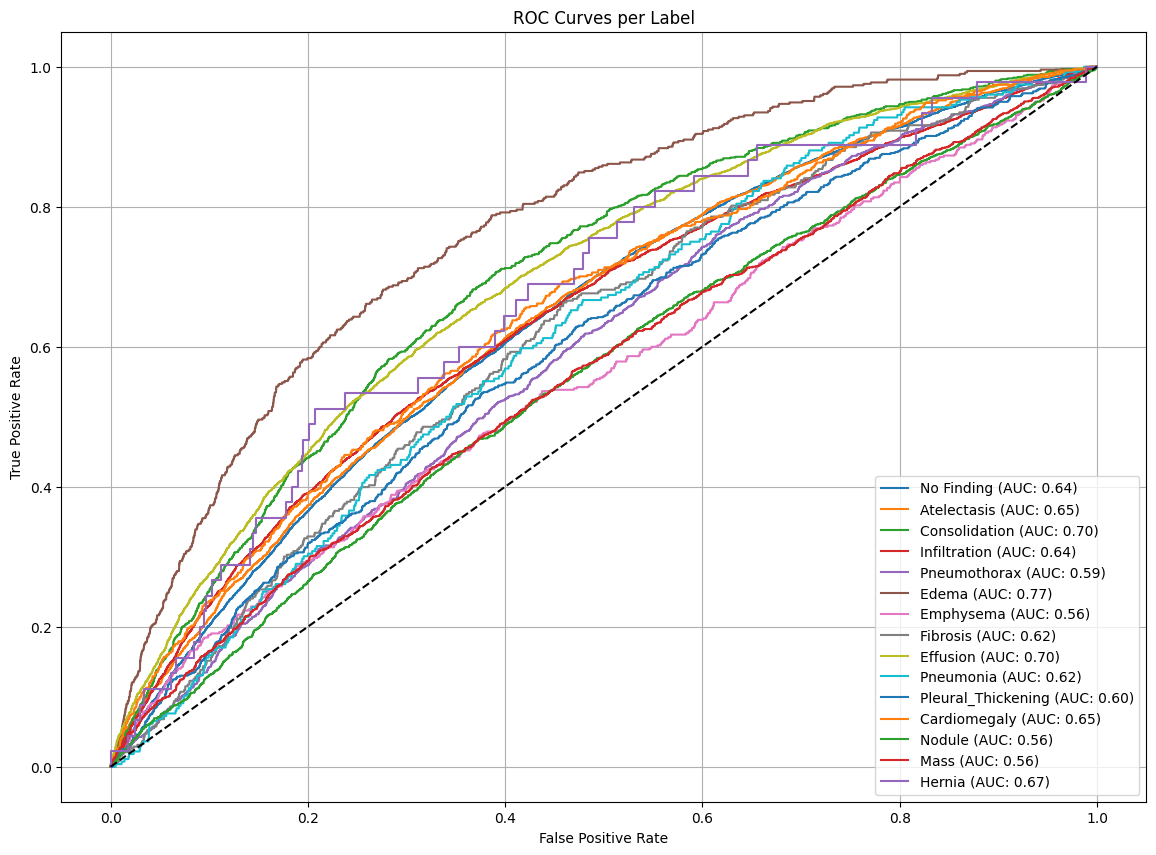

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

y_true = []
y_pred = []

for batch_images, batch_labels in test_ds:
    preds = model.predict(batch_images, verbose=0)
    y_true.append(batch_labels.numpy())
    y_pred.append(preds)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Apply threshold
y_pred_bin = (y_pred >= 0.5).astype(int)

# Per-label AUC scores
print("Per-label AUC scores:")
for i, disease in enumerate(diseases):
    auc = roc_auc_score(y_true[:, i], y_pred[:, i])
    print(f"{disease}: AUC = {auc:.4f}")

# Plot ROC curves
plt.figure(figsize=(14, 10))
for i, disease in enumerate(diseases):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f'{disease} (AUC: {roc_auc_score(y_true[:, i], y_pred[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Label')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Micro AUC — aggregates all decisions and treats them as one binary classification
micro_auc = roc_auc_score(y_true, y_pred, average='micro')

# Macro AUC — average of AUCs per label (unweighted)
macro_auc = roc_auc_score(y_true, y_pred, average='macro')

print(f"Micro AUC: {micro_auc:.4f}")
print(f"Macro AUC: {macro_auc:.4f}")


Micro AUC: 0.8437
Macro AUC: 0.6374


<Figure size 400x400 with 0 Axes>

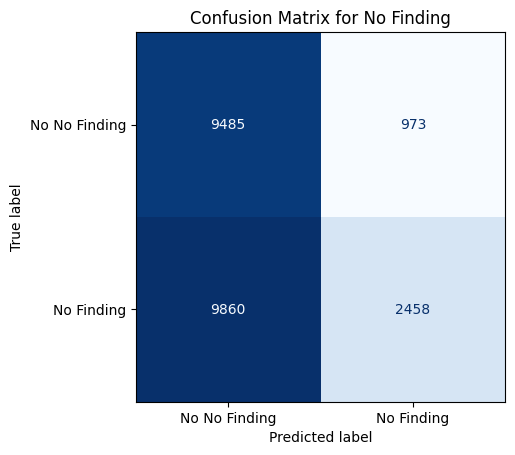

<Figure size 400x400 with 0 Axes>

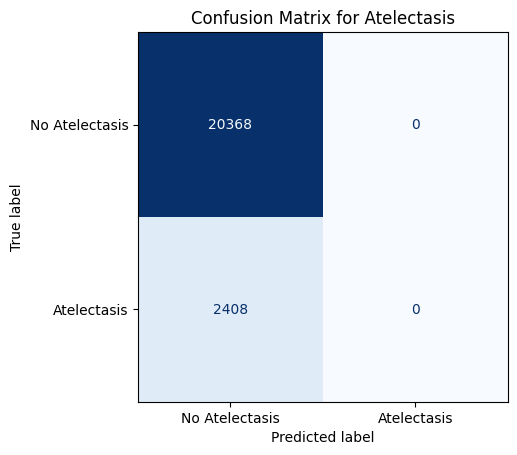

<Figure size 400x400 with 0 Axes>

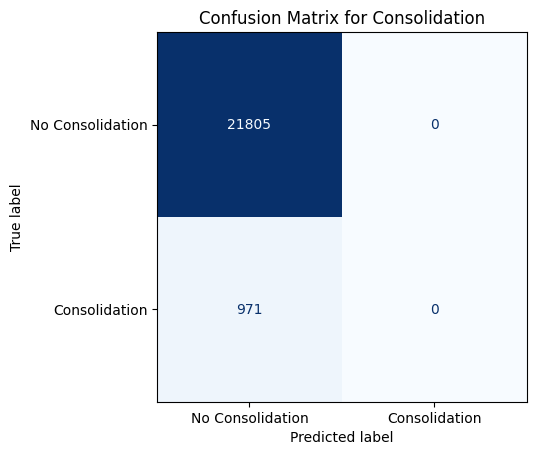

<Figure size 400x400 with 0 Axes>

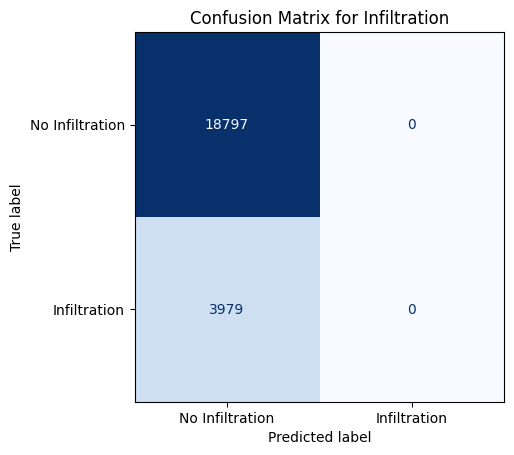

<Figure size 400x400 with 0 Axes>

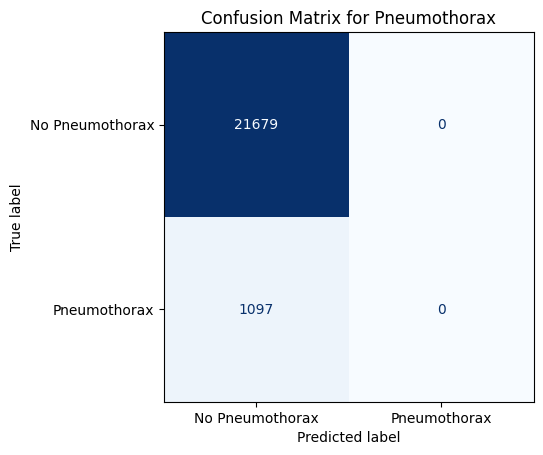

<Figure size 400x400 with 0 Axes>

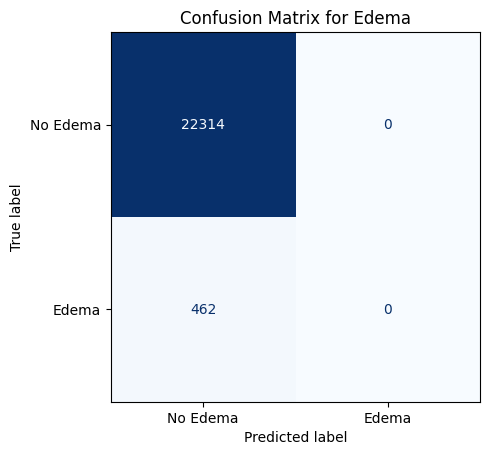

<Figure size 400x400 with 0 Axes>

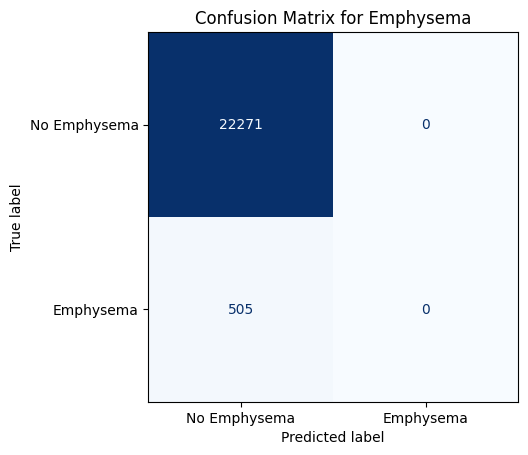

<Figure size 400x400 with 0 Axes>

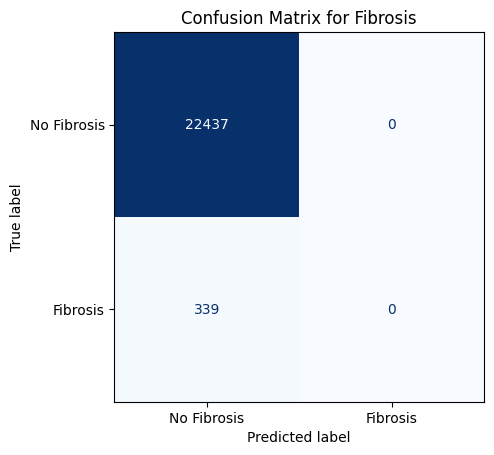

<Figure size 400x400 with 0 Axes>

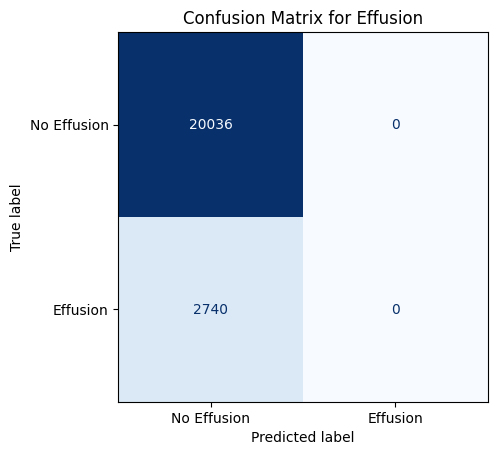

<Figure size 400x400 with 0 Axes>

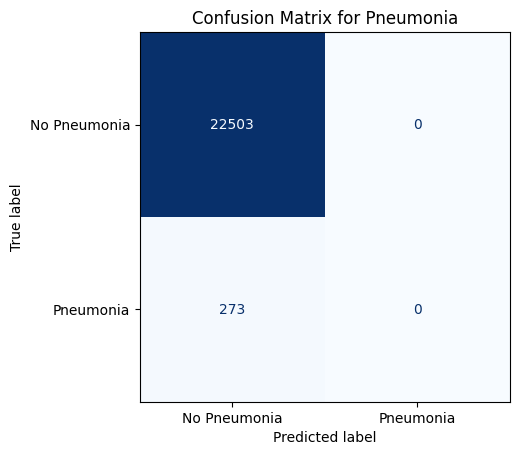

<Figure size 400x400 with 0 Axes>

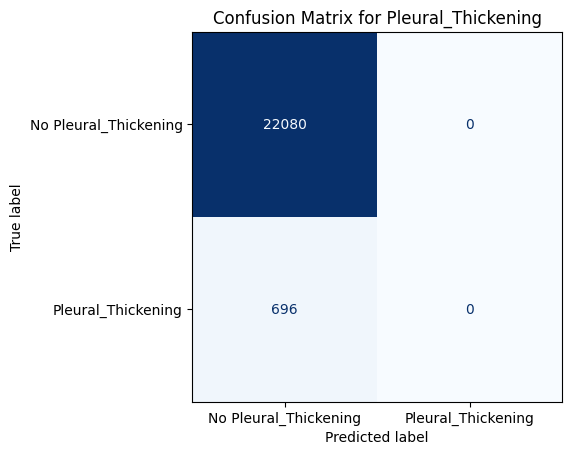

<Figure size 400x400 with 0 Axes>

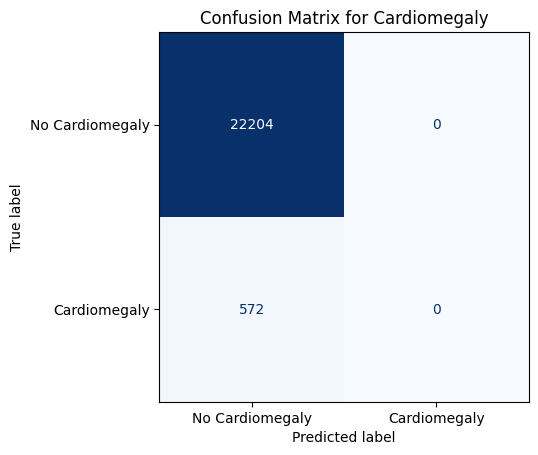

<Figure size 400x400 with 0 Axes>

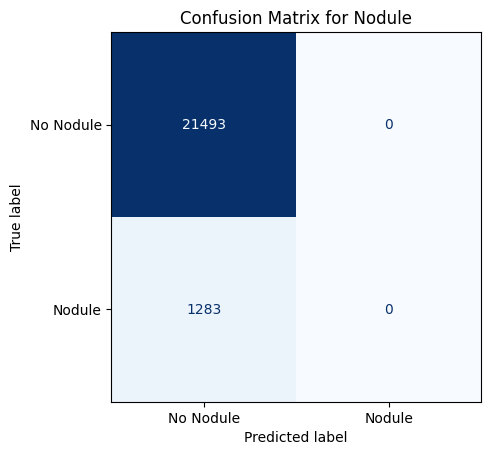

<Figure size 400x400 with 0 Axes>

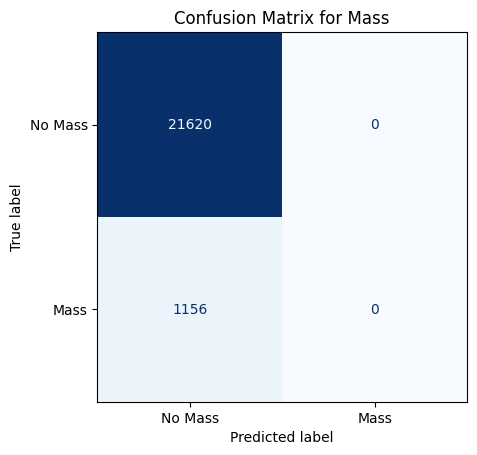

<Figure size 400x400 with 0 Axes>

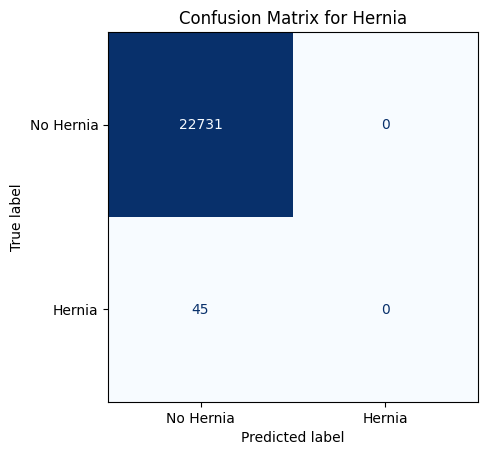

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrices for each label
for i, disease in enumerate(diseases):
    cm = confusion_matrix(y_true[:, i], y_pred_bin[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'No {disease}', disease])

    plt.figure(figsize=(4, 4))
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    plt.title(f'Confusion Matrix for {disease}')
    plt.grid(False)
    plt.show()

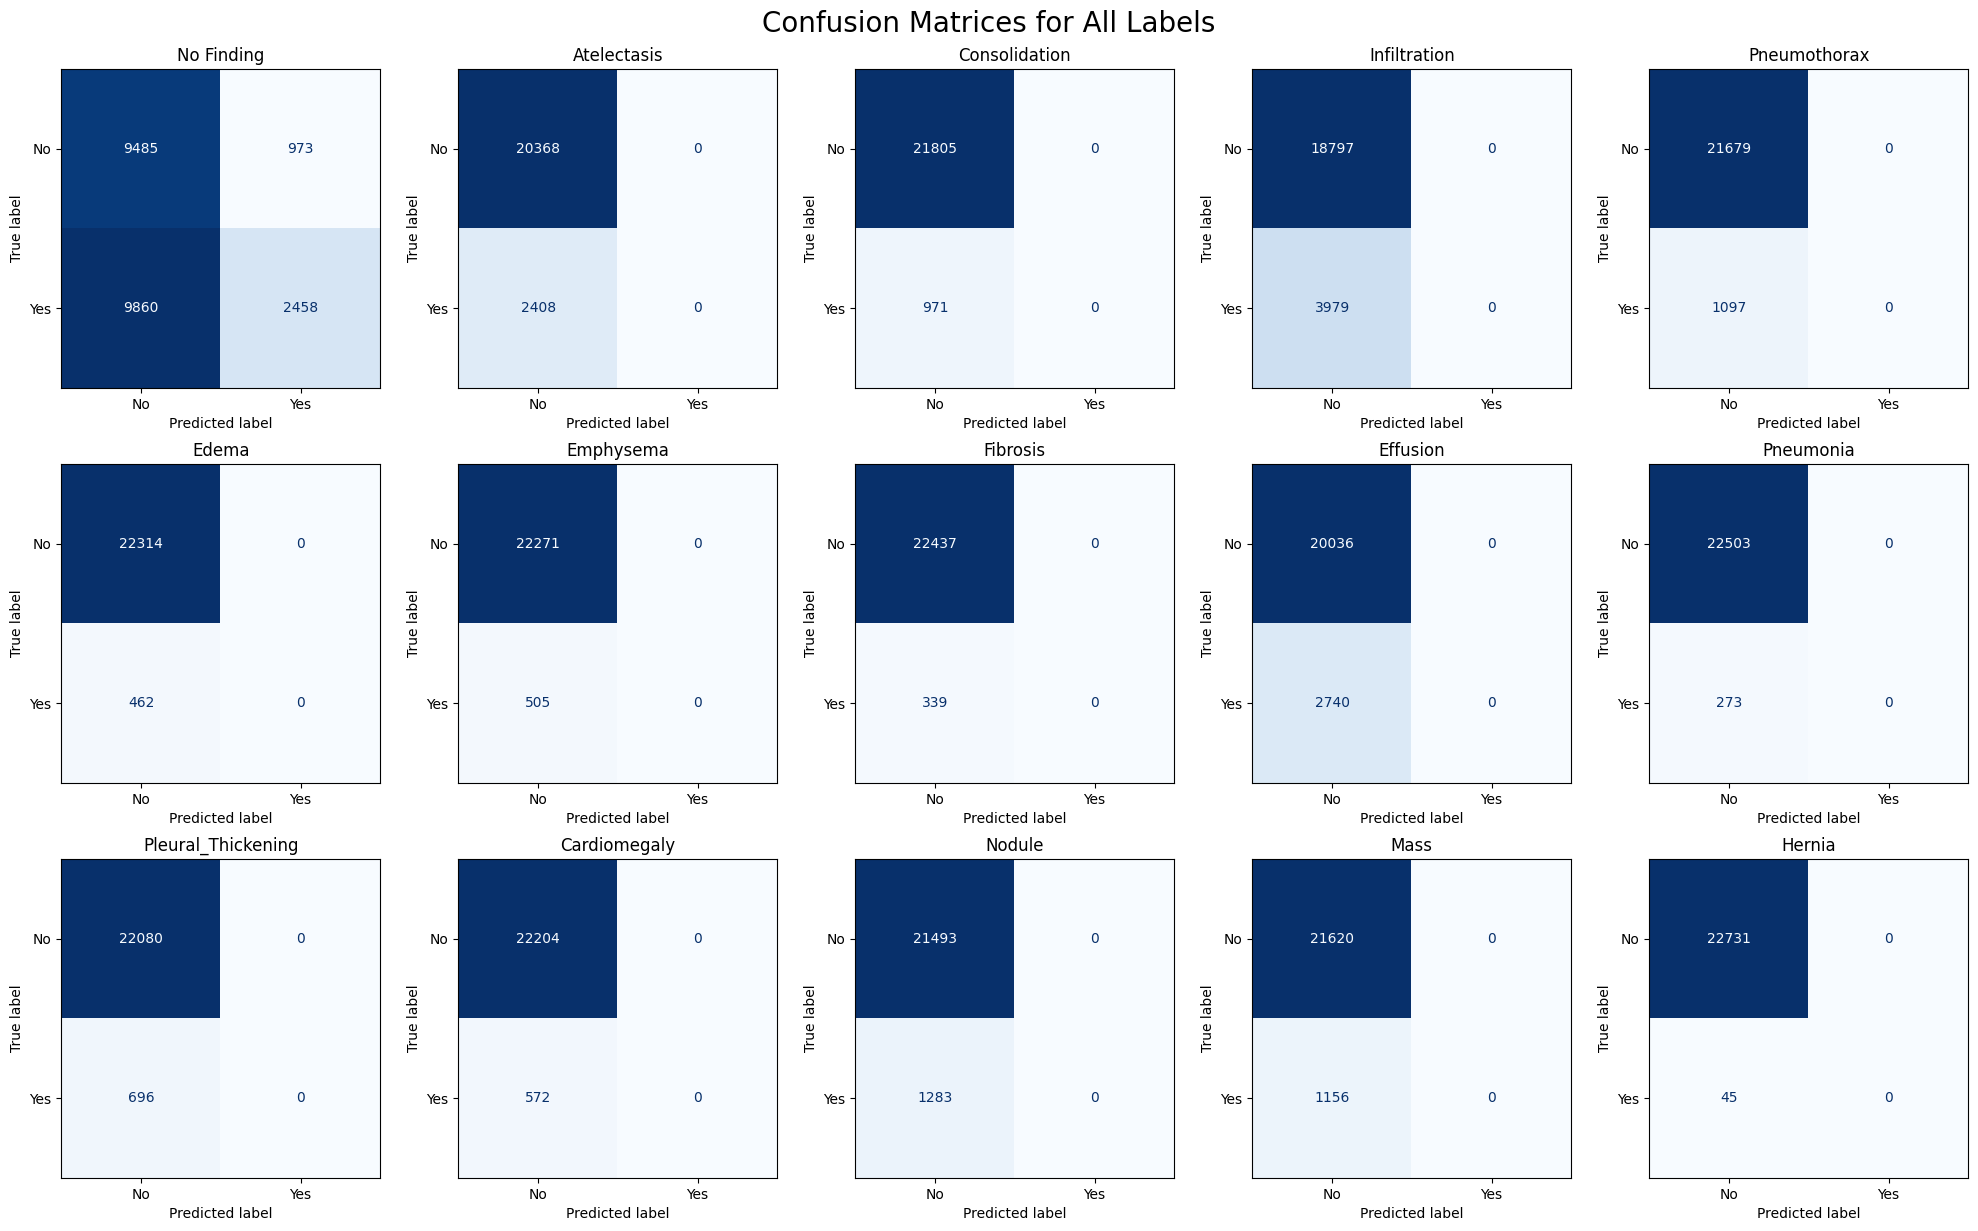

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

num_labels = len(diseases)
cols = 5
rows = (num_labels + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))

for idx, disease in enumerate(diseases):
    r, c = divmod(idx, cols)
    ax = axes[r, c]

    cm = confusion_matrix(y_true[:, idx], y_pred_bin[:, idx])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'No', 'Yes'])
    disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
    ax.set_title(disease)
    ax.grid(False)

# Hide any unused subplots
for i in range(num_labels, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.suptitle("Confusion Matrices for All Labels", fontsize=20, y=1.02)
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

class_names = [
    'No Finding', 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
    'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

report = classification_report(y_true, y_pred_bin, target_names=class_names, zero_division=0)
print(report)


                    precision    recall  f1-score   support

        No Finding       0.70      0.19      0.30     12228
       Atelectasis       0.00      0.00      0.00      2312
     Consolidation       0.00      0.00      0.00       956
      Infiltration       0.00      0.00      0.00      4026
      Pneumothorax       0.00      0.00      0.00      1107
             Edema       0.00      0.00      0.00       490
         Emphysema       0.00      0.00      0.00       520
          Fibrosis       0.00      0.00      0.00       383
          Effusion       0.00      0.00      0.00      2723
         Pneumonia       0.00      0.00      0.00       276
Pleural_Thickening       0.00      0.00      0.00       738
      Cardiomegaly       0.00      0.00      0.00       541
            Nodule       0.00      0.00      0.00      1326
              Mass       0.00      0.00      0.00      1190
            Hernia       0.00      0.00      0.00        45

         micro avg       0.70      0.0